In [4]:
import pandas as pd
import os

# Load CSVs into DataFrames
orders = pd.read_csv("olist_orders_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
product_cat_translation = pd.read_csv("product_category_name_translation.csv")



In [5]:
# Merge orders with customers
order_customer = pd.merge(orders, customers, on='customer_id', how='left')

# Merge with order items
order_details = pd.merge(order_customer, order_items, on='order_id', how='left')

# Merge with payments
order_details = pd.merge(order_details, payments, on='order_id', how='left')

# Merge with reviews
order_details = pd.merge(order_details, reviews, on='order_id', how='left')

# Merge with products
order_details = pd.merge(order_details, products, on='product_id', how='left')

# Merge with category translations
order_details = pd.merge(order_details, product_cat_translation, on='product_category_name', how='left')

# Final shape
order_details.shape


(119143, 37)

In [6]:
# Convert to datetime
order_details['order_purchase_timestamp'] = pd.to_datetime(order_details['order_purchase_timestamp'])

# Create Financial Columns
order_details['total_price'] = order_details['price'] + order_details['freight_value']

# Create Month Column
order_details['order_month'] = order_details['order_purchase_timestamp'].dt.to_period('M')

# Review score handling
order_details['review_score'] = order_details['review_score'].fillna(0)


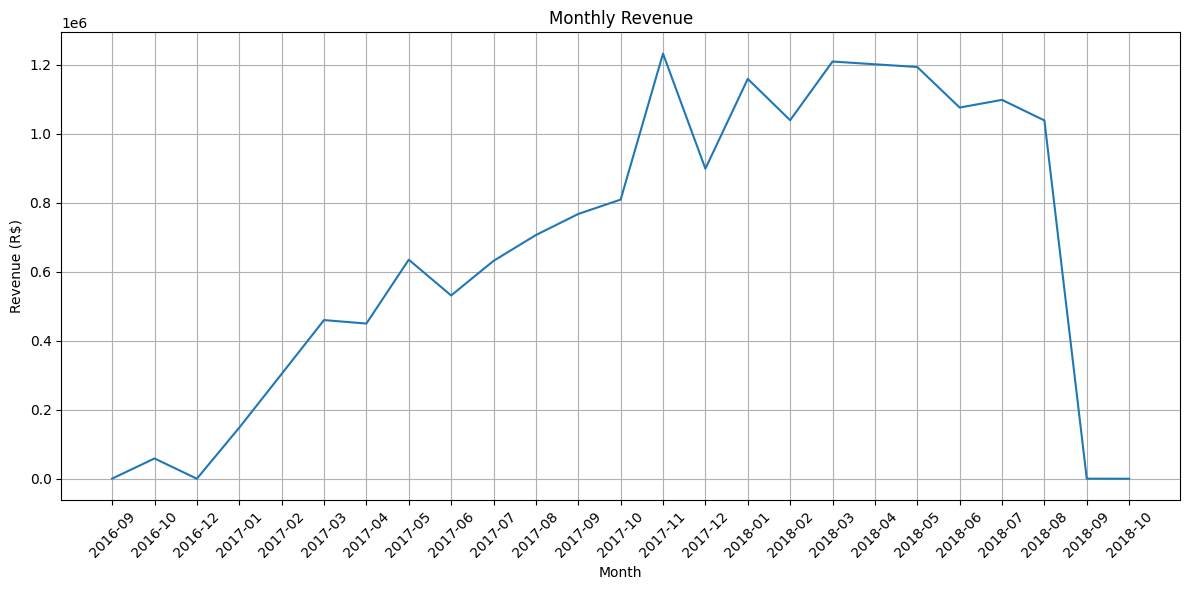

In [7]:
monthly_revenue = order_details.groupby('order_month')['total_price'].sum().reset_index()

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(monthly_revenue['order_month'].astype(str), monthly_revenue['total_price'])
plt.xticks(rotation=45)
plt.title("Monthly Revenue")
plt.ylabel("Revenue (R$)")
plt.xlabel("Month")
plt.grid()
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Revenue by Payment Method'}, xlabel='payment_type'>

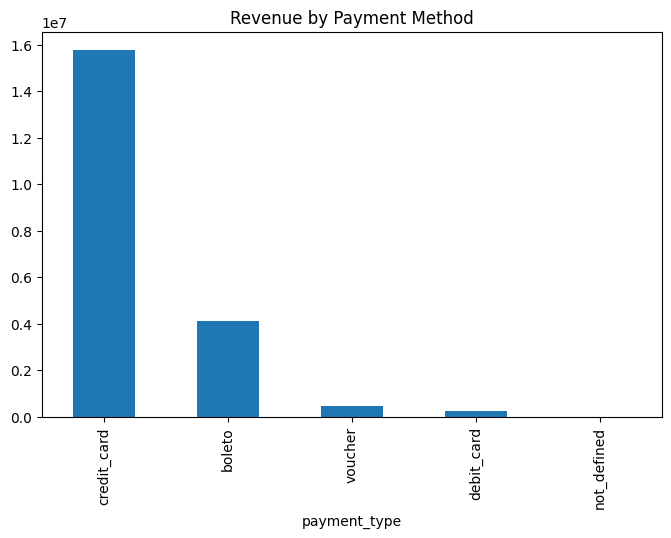

In [8]:
payment_breakdown = order_details.groupby('payment_type')['payment_value'].sum().sort_values(ascending=False)

payment_breakdown.plot(kind='bar', figsize=(8,5), title="Revenue by Payment Method")


In [9]:
from datetime import datetime

# Set reference date
reference_date = order_details['order_purchase_timestamp'].max()

# Group by customer for RFM
rfm = order_details.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (reference_date - x.max()).days,
    'order_id': 'count',
    'total_price': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']
rfm = rfm.dropna()
rfm.head()


,customer_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
2,0000f46a3911fa3c0805444483337064,585,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

kmeans = KMeans(n_clusters=4, random_state=1)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)
rfm['Segment'].value_counts()


c:\Users\hi\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\hi\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\hi\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\hi\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Use

Segment
2    52363
1    38574
0     3713
3     1446
Name: count, dtype: int64

In [11]:
import numpy as np

# Simulate ad spend by product category
ad_spend = order_details.groupby('product_category_name_english')['total_price'].sum() * np.random.uniform(0.05, 0.20, size=order_details['product_category_name_english'].nunique())
ad_spend = ad_spend.reset_index()
ad_spend.columns = ['product_category_name_english', 'ad_spend']

# Merge with sales data
sales_by_category = order_details.groupby('product_category_name_english')['total_price'].sum().reset_index()
marketing = pd.merge(sales_by_category, ad_spend, on='product_category_name_english')
marketing['ROAS'] = marketing['total_price'] / marketing['ad_spend']
marketing.sort_values(by='ROAS', ascending=False).head()


,product_category_name_english,total_price,ad_spend,ROAS
35,flowers,1598.91,80.704119,19.812000
13,cine_photo,8232.24,438.658818,18.766840
19,construction_tools_safety,45966.24,2567.193083,17.905252
48,home_construction,102212.32,5728.887065,17.841567
67,tablets_printing_image,9140.68,517.869465,17.650548


In [13]:
# Save preprocessed data
order_details.to_csv("order_details_clean.csv", index=False)
rfm.to_csv("customer_segments.csv", index=False)
marketing.to_csv("marketing_roas.csv", index=False)
orderd=pd.read_csv("order_details_clean.csv")
orderd.head()
marketing=pd.read_csv("marketing_roas.csv")
marketing.head()
rfmm=pd.read_csv("customer_segments.csv")
rfmm.head()



,customer_id,Recency,Frequency,Monetary,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,2
2,0000f46a3911fa3c0805444483337064,585,1,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89,1
